In [2]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.models import ExactGPModel
from src.variational_dist import VariationalBase
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from src.plotting import plot_grid, plot_gp_predictions, plot_acf_pacf

## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [3]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.75
COORDS = (55.55074, -4.3278)

In [4]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 13 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [6]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

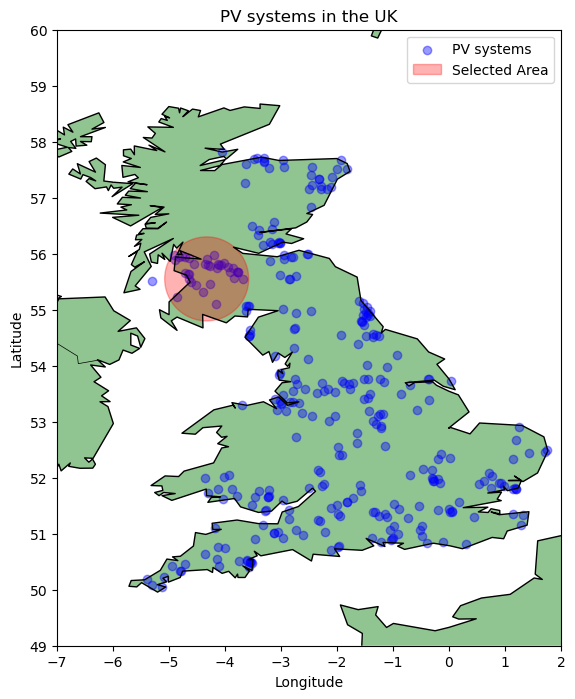

In [7]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [8]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=10,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 13 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [9]:
time, y = loader.get_time_series()

In [10]:
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)

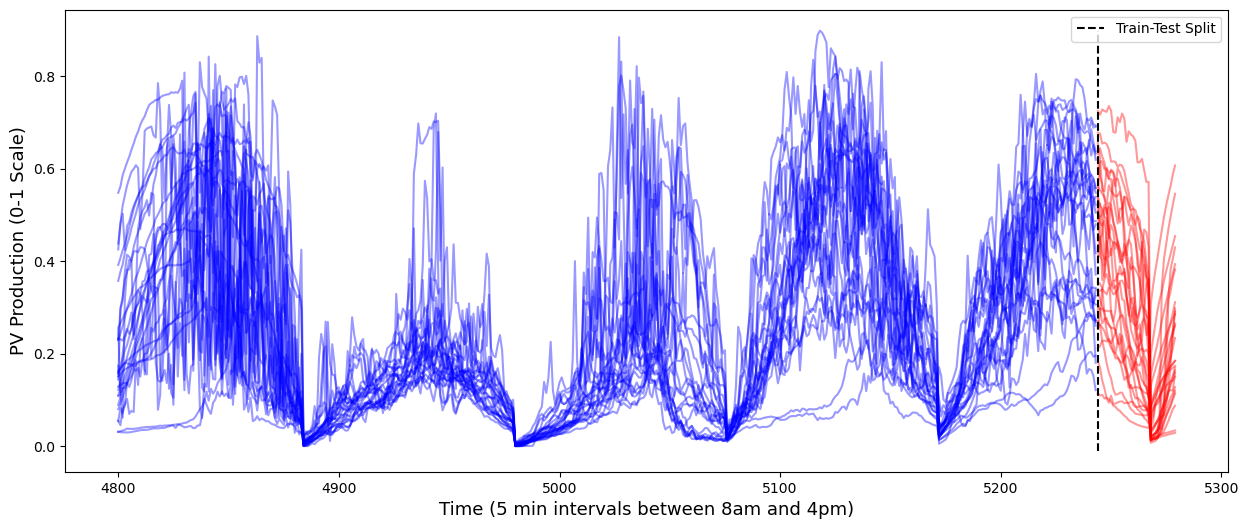

In [11]:
# set figure size
plt.figure(figsize=(15, 6))

# plot the training and test data
plt.plot(time_train, y_train, color='b', alpha=0.4)
plt.plot(time_test, y_test, color='r', alpha=0.4)

# plot the train-test split cutoff
plt.vlines( x= time_train[0] + len(time_train), 
            ymin=-0.01, 
            ymax=max(y_train.max(), y_test.max()), 
            label='Train-Test Split', 
            color='black', 
            linestyle='--')

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)', fontsize=13)
plt.legend()
plt.show();

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [18]:
config = {
    'type': 'stochastic',
    'name': 'cholesky',
    'num_inducing_points': 100,
    'mean_init_std': 1.0,
}
variational = VariationalBase(config)

In [92]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, MeanFieldVariationalDistribution, UnwhitenedVariationalStrategy
from gpytorch.likelihoods import BetaLikelihood, GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, PeriodicKernel, ProductKernel, AdditiveKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
import torch
import gpytorch

# TODO test MeanFieldVariationalDistribution
# TODO test UnwhitenedVariationalStrategy
# TODO test different kernels
# TODO test different likelihoods
# TODO add confidence region for beta likelihood
# TODO make it take configuration dictionary as input for the variational distribution
# TODO create fit function for natural variational distribution

class ApproximateGPBaseModel(ApproximateGP):
    """ 
    Base model for performing inference with a Gaussian Process (GP) using
    stochastic variational inference (SVI) with inducing points which can be
    scaled to large datasets. 
    
    For a guide to GPs and SVI, see the following paper:
    https://arxiv.org/abs/1309.6835

    Args:
        train_x (torch.Tensor): training data
        likelihood (gpytorch.likelihoods.Likelihood): likelihood
        variational_distribution (gpytorch.variational.VariationalDistribution): variational distribution
    """

    def __init__(self, train_x : torch.Tensor, 
                 likelihood : gpytorch.likelihoods.Likelihood, 
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-4,
                 learn_inducing_locations : bool = False
                 ):
        variational_distribution = VariationalBase(config).variational_distribution
        variational_strategy = VariationalStrategy(self, 
                                                   inducing_points=train_x, 
                                                   variational_distribution=variational_distribution,
                                                   learn_inducing_locations=learn_inducing_locations,
                                                   jitter_val=jitter) 
        
        super(ApproximateGPBaseModel, self).__init__(variational_strategy)
        
        # TODO change this to accept exogenous variables
        
        dims = 1 if len(train_x.shape) == 1 else train_x.shape[1]
        
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood
    
    def forward(self, x):
        """ 
        Model prediction of the GP model

        Args:
            x (torch.Tensor): input data
        
        Returns:
            latent_u (gpytorch.distributions.MultivariateNormal): GP model 
                                                                   f(x), where f ~ GP( m(x), k(x, x))
        """
        
        mu = self.mean_module(x)
        k = self.covar_module(x)

        return MultivariateNormal(mu, k)
        
    def fit(self, 
            n_iter : int, 
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device, verbose : bool = True):
        """
        Train the GP model using SVI

        Args:
            n_iter (int): number of iterations
            lr (float): learning rate
            optim (str): optimizer
            device (torch.device): device to train on
            verbose (bool): whether to print training progress
        """
        self.to(device)
        
        self.train()
        self.likelihood.train()

        optimizer = optim(self.parameters(), lr=lr)
        elbo = gpytorch.mlls.VariationalELBO(likelihood=self.likelihood, 
                                            model=self, 
                                            num_data=self.y.size(0))
        
        print_freq = n_iter // 10
        self.losses = []
        
        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -elbo(output, self.y)
            loss.backward()
            optimizer.step()

            self.losses.append(loss.item())

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter {i+1}/{n_iter} - Loss: {loss.item():.3f}')
    
    def predict(self, X : torch.Tensor, device : torch.device):
        """ 
        Make predictions with the GP model

        Args:
            X (torch.Tensor): test data
            device (torch.device): device to make predictions on

        Returns:
            preds (gpytorch.distributions.MultivariateNormal): predictive mean and variance
        """
        self.eval()
        self.likelihood.eval()
        
        self.to(device)
        self.likelihood.to(device)

        with torch.no_grad():
           
            if not isinstance(self.likelihood, GaussianLikelihood):
                with gpytorch.settings.num_likelihood_samples(30):
                    preds = self.likelihood(self(X))
            else:
                preds = self.likelihood(self(X))
            
        return preds

class GaussianGP(ApproximateGPBaseModel):
    """ 
    Stochastic Variational Inference GP model for regression using
    inducing points for scalability and a Gaussian likelihood for unbounded outputs

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self, 
                 X : torch.Tensor, 
                 y : torch.Tensor, 
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-6,
                 ):
        
        super(GaussianGP, self).__init__(train_x=X, 
                                         likelihood=GaussianLikelihood(), 
                                         mean_module=mean_module,
                                         covar_module=covar_module,
                                         config=config,
                                         jitter=jitter)
        self.X = X
        self.y = y

class BetaGP(ApproximateGPBaseModel):
    """ 
    Stochastic Variational Inference GP model for regression using
    inducing points for scalability and a Beta likelihood for bounded outputs
    in the range [0, 1]

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self, 
                 X : torch.Tensor, 
                 y : torch.Tensor,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-4,
                 ):
        
        assert y.min() >= 0 and y.max() <= 1, 'y must be in the range [0, 1] for Beta likelihood'
        
        # add perturbation to the data to avoid numerical issues for bounded outputs
        if y.min() == 0:
            y += jitter
        
        if y.max() == 1:
            y -= jitter
        
        super(BetaGP, self).__init__(train_x=X,
                                     likelihood=BetaLikelihood(), 
                                     mean_module=mean_module,
                                     covar_module=covar_module,
                                     config=config,
                                     jitter=jitter)
        self.X = X
        self.y = y

In [93]:
matern = MaternKernel(nu=5/2, ard_num_dims=1)
quasi_periodic = ProductKernel(MaternKernel(nu=5/2), PeriodicKernel())
scaled_additive = ScaleKernel(AdditiveKernel(matern, quasi_periodic))

In [111]:
idx = 12
y_in = y[:,idx] + 1e-4
x_train, y_train, x_test, y_test = dl.train_test_split(time, y_in, n_hours=3)

idx = np.random.choice(x_train.shape[0], 350, replace=False)
x_inducing = x_train[idx]
y_inducing = y_train[idx]

config = {
    'type': 'stochastic',
    'name': 'cholesky',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-4,
}

model = BetaGP(X=x_inducing, 
               y=y_inducing,
               mean_module=ConstantMean(),
               covar_module=ScaleKernel(scaled_additive),
               config=config,
               jitter=1e-2
                )
model.fit(n_iter=500, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))

preds = model.predict(x_test, device=torch.device('cpu'))

                     

Iter 50/500 - Loss: -0.858
Iter 100/500 - Loss: -1.088
Iter 150/500 - Loss: -1.201
Iter 200/500 - Loss: -1.274
Iter 250/500 - Loss: -1.328
Iter 300/500 - Loss: -1.372
Iter 350/500 - Loss: -1.409
Iter 400/500 - Loss: -1.439
Iter 450/500 - Loss: -1.455
Iter 500/500 - Loss: -1.485


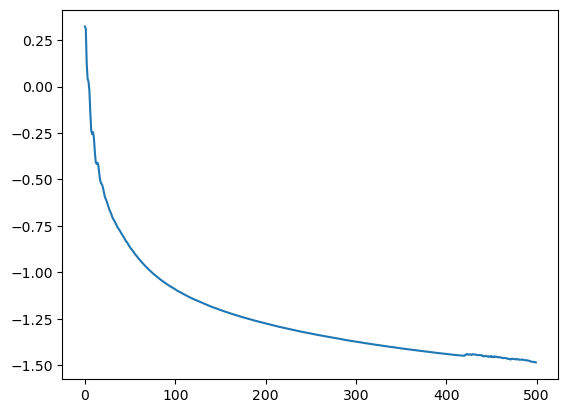

In [112]:
plt.plot(model.losses)

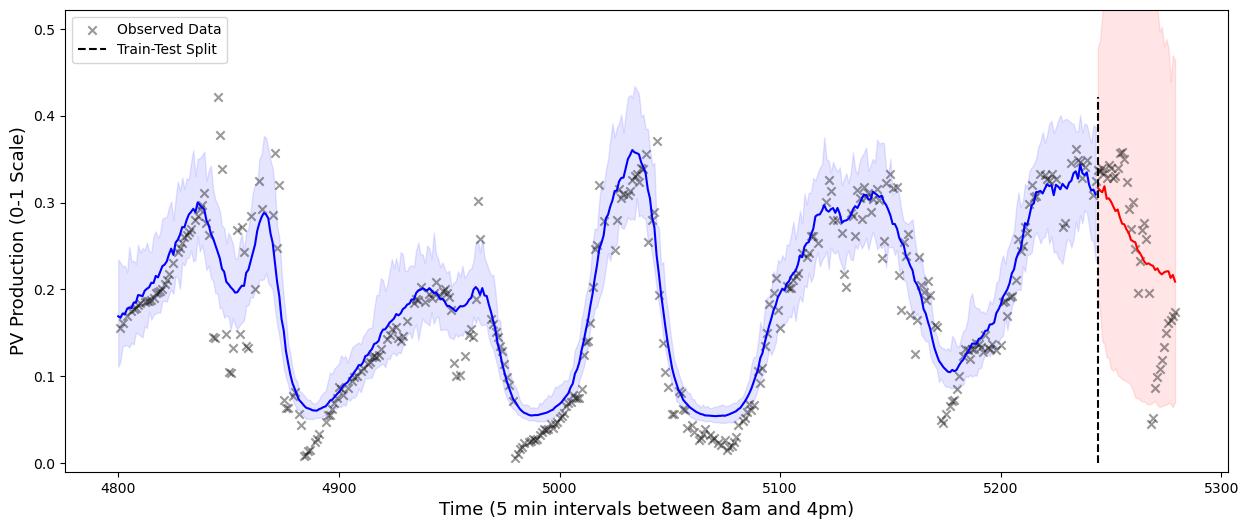

In [113]:
preds_train = model.predict(X=x_train, device=torch.device('cpu'))
preds_test = model.predict(X=x_test, device=torch.device('cpu'))

with torch.no_grad():
    plt.figure(figsize=(15, 6))

    plt.plot(x_train, preds_train.mean.mean(axis=0), color='b')
    lower_train, upper_train = np.percentile(preds_train.mean, q=[5, 95], axis=0)
    plt.fill_between(x_train, lower_train, upper_train, alpha=0.1, color='b')
    
    plt.plot(x_test, preds_test.mean.mean(axis=0), color='r')
    lower_test, upper_test = np.percentile(preds_test.mean, q=[2.5, 97.5], axis=0)
    plt.fill_between(x_test, lower_test, upper_test, alpha=0.1, color='r')
    
    # plt.scatter(x_train, y_train, color='k', alpha=0.4, marker='x')
    plt.scatter(x_test, y_test, color='k', alpha=0.4, marker='x')
    # scatter inducing points
    inducing_points = model.variational_strategy.inducing_points
    plt.scatter(inducing_points, y_inducing, color='k', marker='x', label='Observed Data', alpha=0.4)

    plt.vlines(x=x_train.min() + len(x_train), ymin=0, ymax=max(y_train.max(), y_test.max()),
                color='black', linestyle='--', label='Train-Test Split')

    plt.ylim(-0.01, y_in.max() + 0.1)
    plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
    plt.ylabel('PV Production (0-1 Scale)', fontsize=13)

    plt.legend(loc='upper left')
    

In [114]:
matern = MaternKernel(nu=5/2, ard_num_dims=1)
quasi_periodic = ProductKernel(MaternKernel(nu=5/2, ard_num_dims=1), PeriodicKernel())
scaled_additive = ScaleKernel(AdditiveKernel(matern, quasi_periodic))

In [123]:
config = {
    'type': 'stochastic',
    'name': 'cholesky',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-3,
}

model = GaussianGP(X=x_inducing, 
                   y=y_inducing,
                   mean_module=ConstantMean(),
                   covar_module=ScaleKernel(quasi_periodic),
                   config=config,
                   jitter=1e-3
                   )
model.fit(n_iter=150, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 15/150 - Loss: 0.489
Iter 30/150 - Loss: -0.302
Iter 45/150 - Loss: -0.977
Iter 60/150 - Loss: -1.141
Iter 75/150 - Loss: -1.285
Iter 90/150 - Loss: -1.343
Iter 105/150 - Loss: -1.367
Iter 120/150 - Loss: -1.380
Iter 135/150 - Loss: -1.359
Iter 150/150 - Loss: -1.382


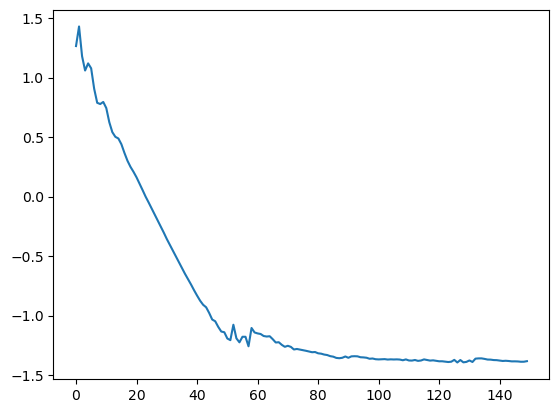

In [124]:
plt.plot(model.losses)

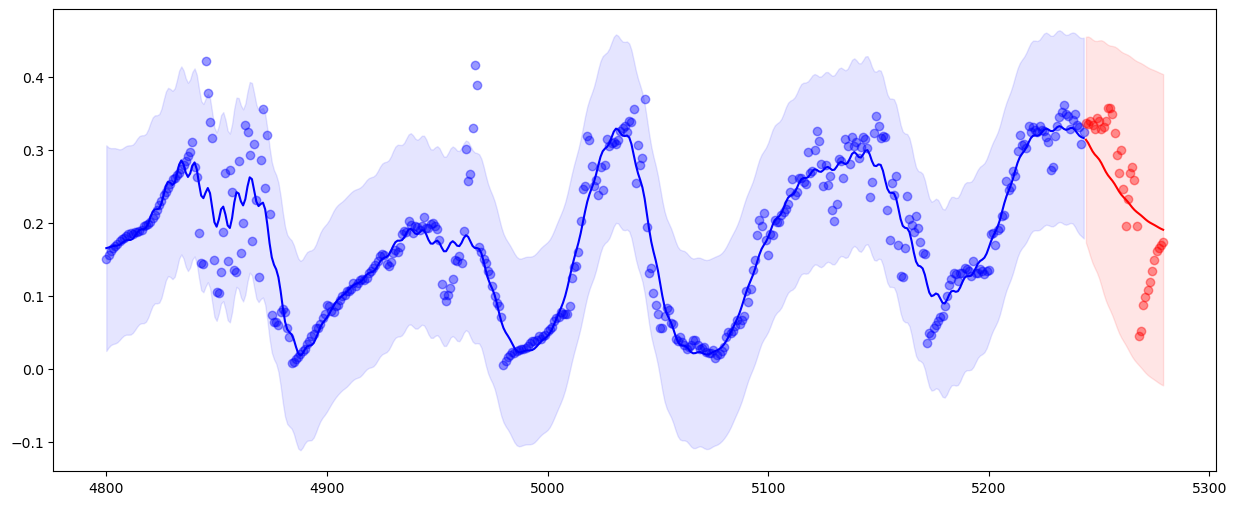

In [125]:
preds_train = model.predict(X=x_train, device=torch.device('cpu'))
preds_test = model.predict(X=x_test, device=torch.device('cpu'))

with torch.no_grad():
    plt.figure(figsize=(15, 6))
    plt.plot(x_train, preds_train.mean, color='b')
    plt.plot(x_test, preds_test.mean, color='r')
    plt.scatter(x_train, y_train, color='b', alpha=0.4)
    plt.scatter(x_test, y_test, color='r', alpha=0.4)

    lower, upper = preds_train.confidence_region()
    plt.fill_between(x_train, lower, upper, alpha=0.1, color='b')

    lower, upper = preds_test.confidence_region()
    plt.fill_between(x_test, lower, upper, alpha=0.1, color='r')
    

# TO DO - Fix plotting to include inducing points

Iter 10/100 - Loss: 1.010
Iter 20/100 - Loss: 0.791
Iter 30/100 - Loss: 0.572
Iter 40/100 - Loss: 0.334
Iter 50/100 - Loss: 0.062
Iter 60/100 - Loss: -0.208
Iter 70/100 - Loss: -0.459
Iter 80/100 - Loss: -0.611
Iter 90/100 - Loss: -0.802
Iter 100/100 - Loss: -0.947


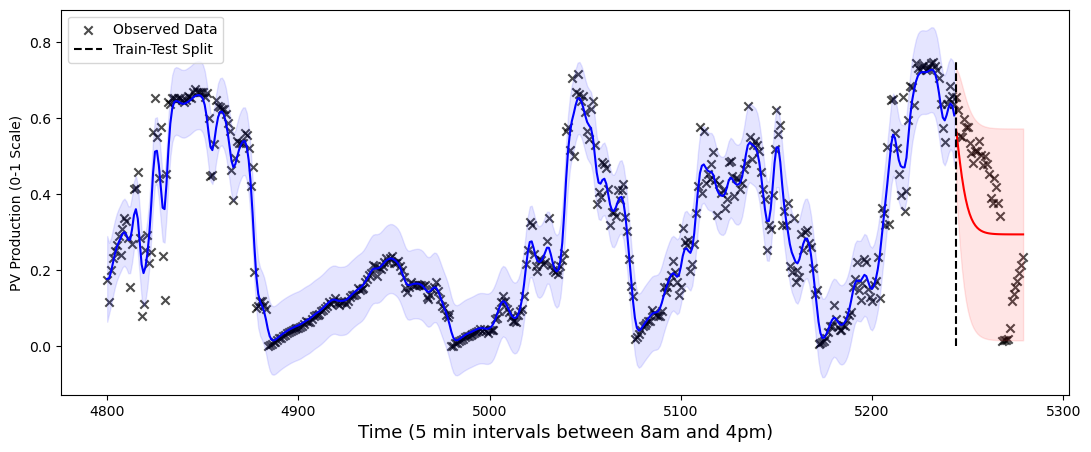

Iter 10/100 - Loss: 0.967
Iter 20/100 - Loss: 0.746
Iter 30/100 - Loss: 0.518
Iter 40/100 - Loss: 0.270
Iter 50/100 - Loss: -0.020
Iter 60/100 - Loss: -0.311
Iter 70/100 - Loss: -0.591
Iter 80/100 - Loss: -0.801
Iter 90/100 - Loss: -1.066
Iter 100/100 - Loss: -1.304


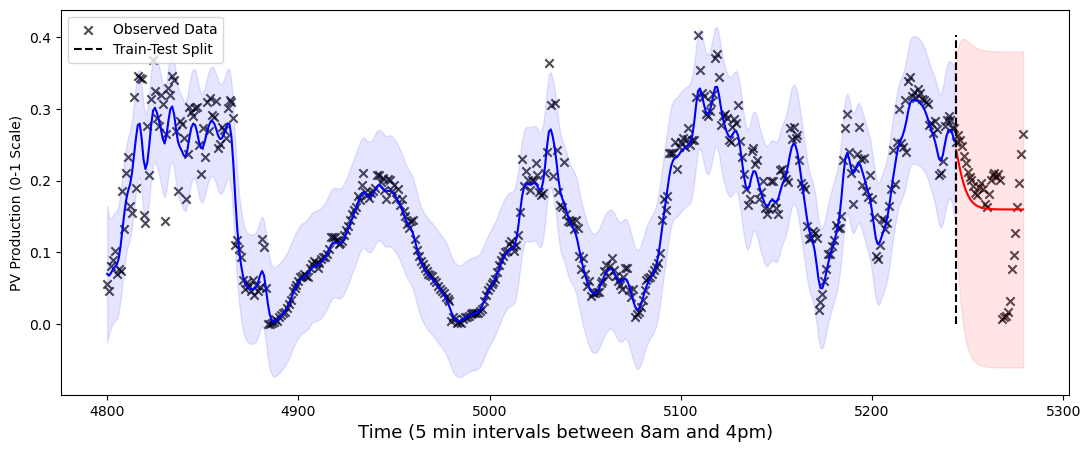

Iter 10/100 - Loss: 0.958
Iter 20/100 - Loss: 0.738
Iter 30/100 - Loss: 0.508
Iter 40/100 - Loss: 0.256
Iter 50/100 - Loss: -0.039
Iter 60/100 - Loss: -0.332
Iter 70/100 - Loss: -0.619
Iter 80/100 - Loss: -0.851
Iter 90/100 - Loss: -1.116
Iter 100/100 - Loss: -1.394


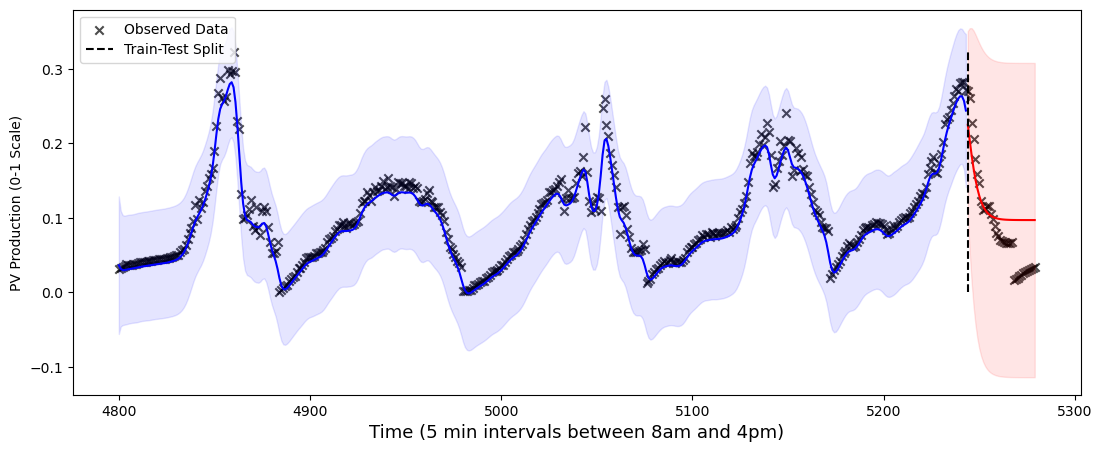

Iter 10/100 - Loss: 0.981
Iter 20/100 - Loss: 0.761
Iter 30/100 - Loss: 0.534
Iter 40/100 - Loss: 0.287
Iter 50/100 - Loss: -0.001
Iter 60/100 - Loss: -0.285
Iter 70/100 - Loss: -0.560
Iter 80/100 - Loss: -0.748
Iter 90/100 - Loss: -1.001
Iter 100/100 - Loss: -1.225


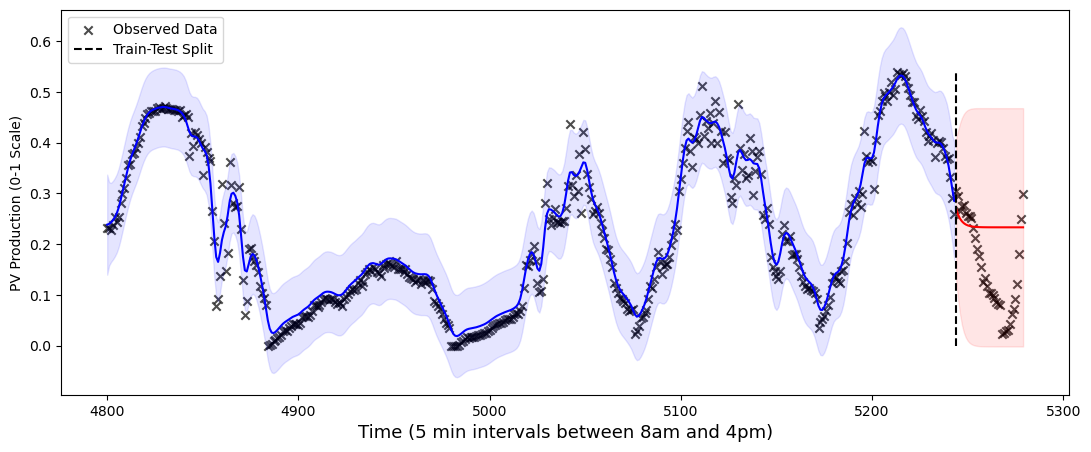

Iter 10/100 - Loss: 0.992
Iter 20/100 - Loss: 0.772
Iter 30/100 - Loss: 0.548
Iter 40/100 - Loss: 0.306
Iter 50/100 - Loss: 0.025
Iter 60/100 - Loss: -0.256
Iter 70/100 - Loss: -0.523
Iter 80/100 - Loss: -0.701
Iter 90/100 - Loss: -0.930
Iter 100/100 - Loss: -1.128


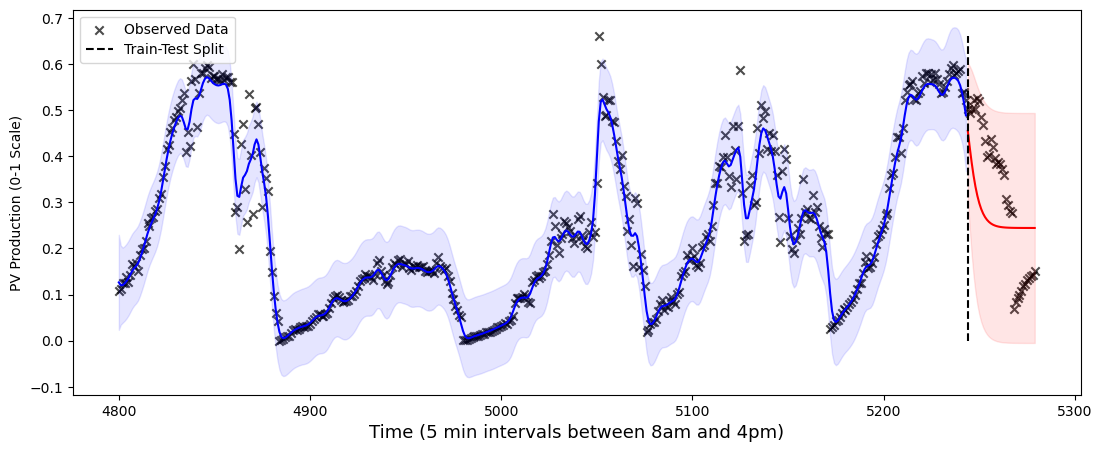

Iter 10/100 - Loss: 1.006
Iter 20/100 - Loss: 0.787
Iter 30/100 - Loss: 0.567
Iter 40/100 - Loss: 0.328
Iter 50/100 - Loss: 0.054
Iter 60/100 - Loss: -0.211
Iter 70/100 - Loss: -0.455
Iter 80/100 - Loss: -0.586
Iter 90/100 - Loss: -0.767
Iter 100/100 - Loss: -0.899


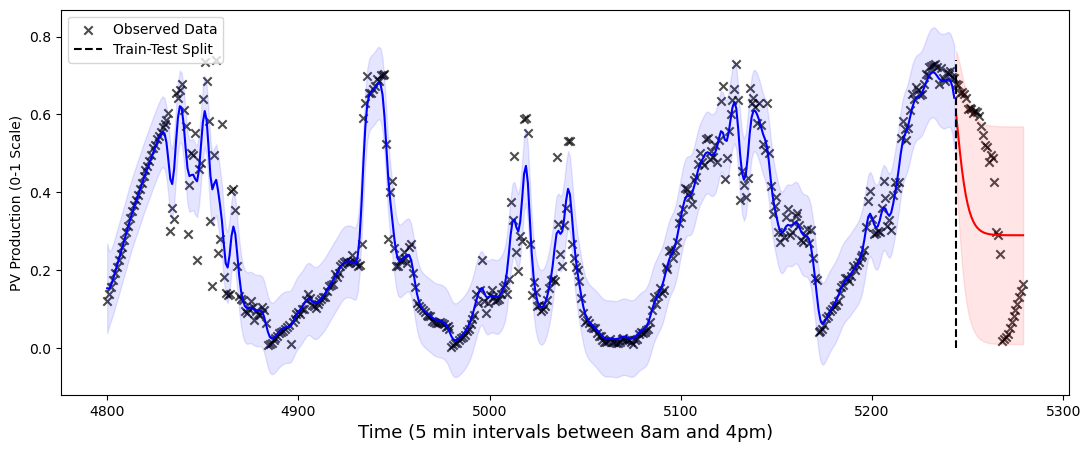

Iter 10/100 - Loss: 1.021
Iter 20/100 - Loss: 0.804
Iter 30/100 - Loss: 0.587
Iter 40/100 - Loss: 0.351
Iter 50/100 - Loss: 0.082
Iter 60/100 - Loss: -0.177
Iter 70/100 - Loss: -0.414
Iter 80/100 - Loss: -0.540
Iter 90/100 - Loss: -0.698
Iter 100/100 - Loss: -0.823


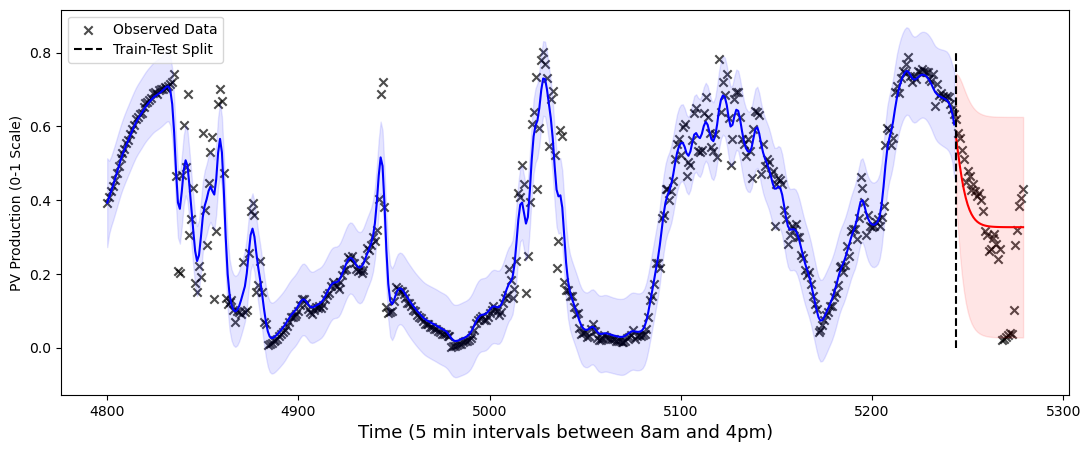

Iter 10/100 - Loss: 1.001
Iter 20/100 - Loss: 0.781
Iter 30/100 - Loss: 0.560
Iter 40/100 - Loss: 0.318
Iter 50/100 - Loss: 0.041
Iter 60/100 - Loss: -0.229
Iter 70/100 - Loss: -0.482
Iter 80/100 - Loss: -0.626
Iter 90/100 - Loss: -0.827
Iter 100/100 - Loss: -0.983


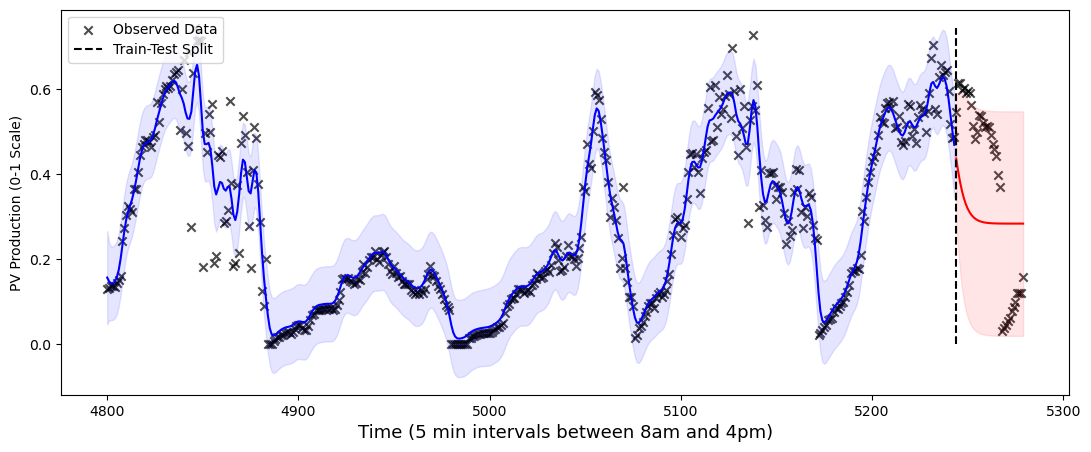

Iter 10/100 - Loss: 0.959
Iter 20/100 - Loss: 0.738
Iter 30/100 - Loss: 0.508
Iter 40/100 - Loss: 0.258
Iter 50/100 - Loss: -0.035
Iter 60/100 - Loss: -0.331
Iter 70/100 - Loss: -0.619
Iter 80/100 - Loss: -0.844
Iter 90/100 - Loss: -1.129
Iter 100/100 - Loss: -1.400


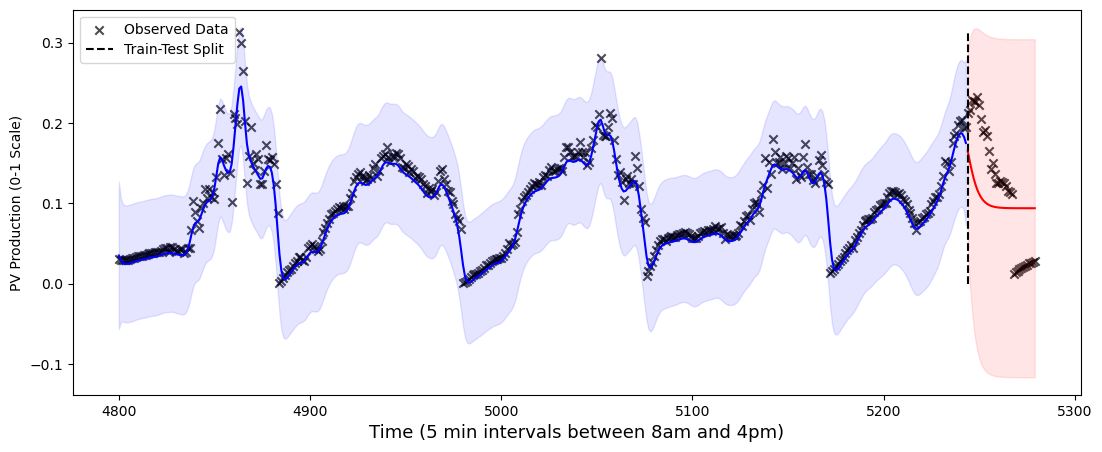

Iter 10/100 - Loss: 1.019
Iter 20/100 - Loss: 0.803
Iter 30/100 - Loss: 0.586
Iter 40/100 - Loss: 0.352
Iter 50/100 - Loss: 0.084
Iter 60/100 - Loss: -0.179
Iter 70/100 - Loss: -0.421
Iter 80/100 - Loss: -0.559
Iter 90/100 - Loss: -0.731
Iter 100/100 - Loss: -0.861


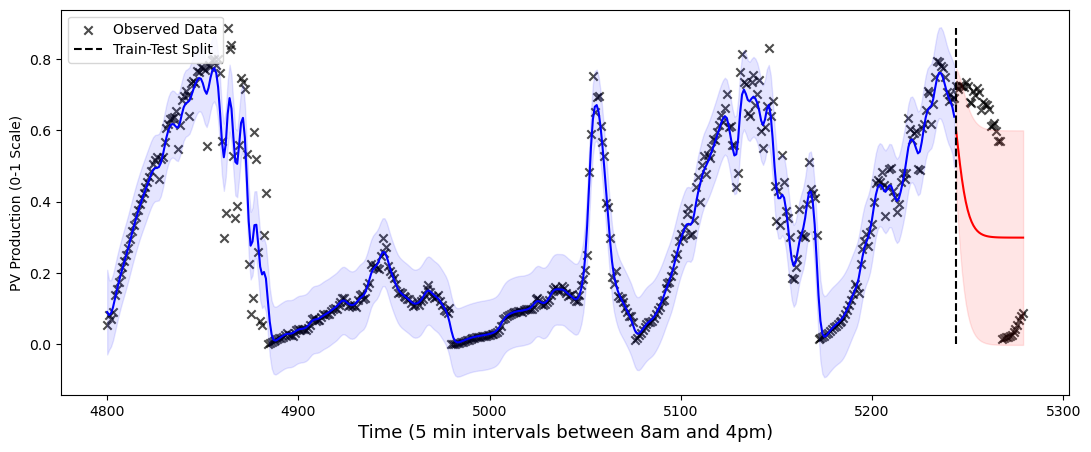

In [130]:
N = 10 if y_train.shape[1] > 10 else y_train.shape[1]
for idx in range(N):
    model = GaussianGP(X=time_train, y=y_train[:,idx])
    model.fit(n_iter=100, lr=0.05, optim=torch.optim.Adam, device=torch.device('cpu'))

    pred_train = model(time_train)
    pred_test = model(time_test)

    with torch.no_grad():
        plot_gp_predictions(pred_train, pred_test, time_train.detach().numpy(), time_test.detach().numpy(), y_train[:,idx], y_test[:,idx])

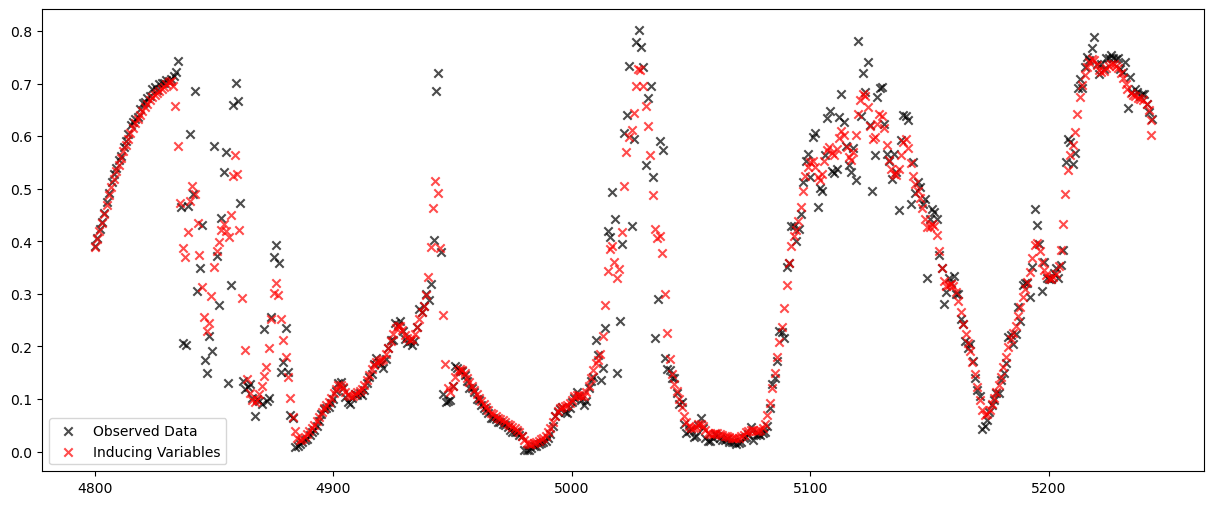

In [114]:
# plot inducing variables vs training data
plt.figure(figsize=(15, 6))
plt.scatter(model.X.detach().numpy(), model.y.detach().numpy(), marker='x', color='black', alpha=0.7, label='Observed Data')
plt.scatter(model.variational_strategy.inducing_points.detach().numpy(), pred_train.mean.detach().numpy(), marker='x', color='red', alpha=0.7, label='Inducing Variables')
plt.legend()
plt.show();

# Baselines

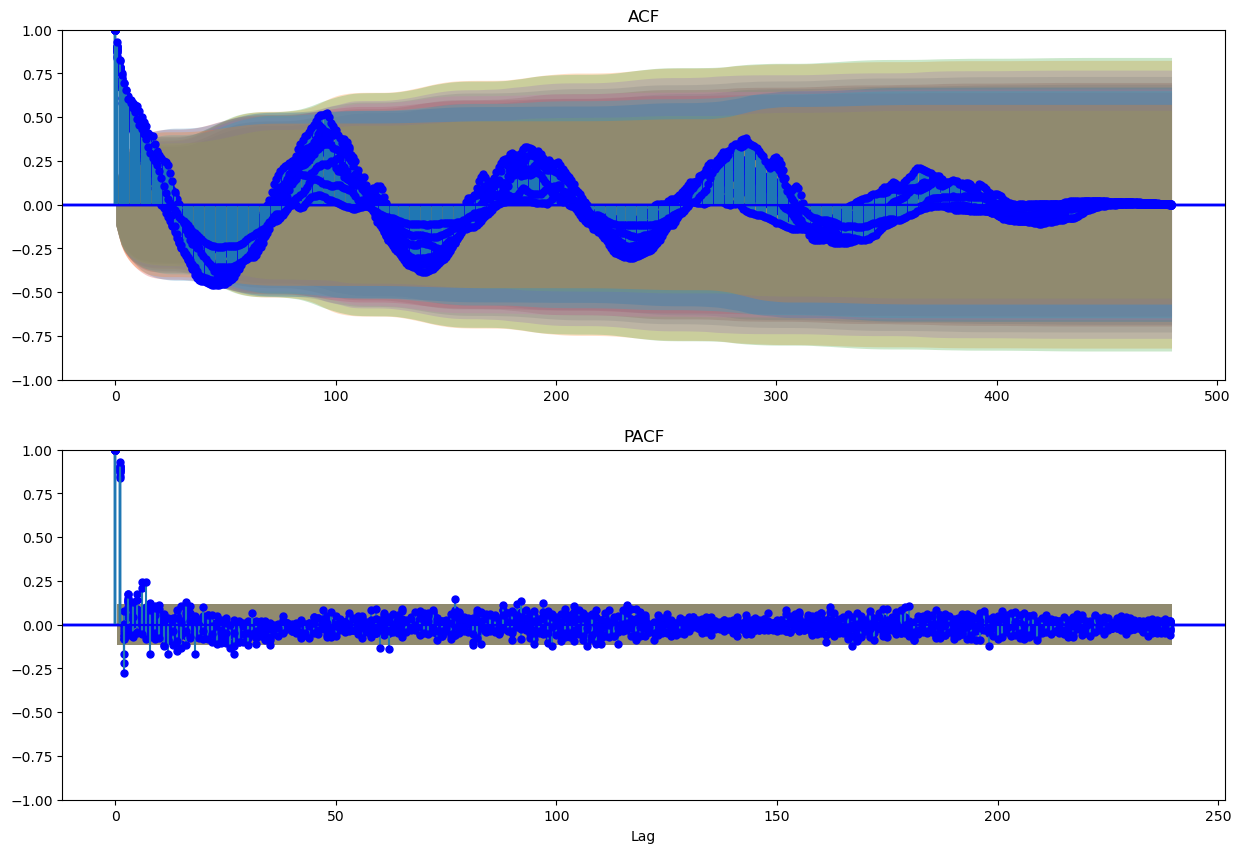

In [66]:
# create function for plotting acf and pacf for all systems in a grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(y):
    """
    Plot the acf and pacf for all systems in a grid
    """
    _, ax = plt.subplots(2, 1, figsize=(15, 10))
    for i in range(y.shape[1]):
        plot_acf(y[:, i], ax=ax[0], alpha=0.01, lags=len(y) - 1, title='ACF', color='b')
        plot_pacf(y[:, i], ax=ax[1], alpha=0.01, lags=len(y) // 2 - 1, title='PACF', color='b', method='ywm')
    
    plt.xlabel('Lag')
    
    plt.show()

plot_acf_pacf(y)
    


# TODO!! Decide how to use ACF / PACF on selecting amount of data to GP Model & Time Series Models

In [419]:
from statsmodels.tsa.api import AutoReg, ARIMA, SARIMAX, ExponentialSmoothing, MarkovAutoregression


class BaseLineModels:
    """ 
    Global class for time series forecasting models
    
    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, time_train, y_train, time_test, y_test):
        self.time_train = time_train
        self.y_train = y_train
        self.time_test = time_test
        self.y_test = y_test
    
    def exponential_smoothing(self, **kwargs):
        """
        Exponential smoothing model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def arima(self, **kwargs):
        """
        ARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarima(self, **kwargs):
        """
        SARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarimax(self, **kwargs):
        """
        SARIMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def var(self, **kwargs):
        """
        VAR model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def varmax(self, **kwargs):
        """
        VARMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    

In [425]:
class ExponentialModels(ExponentialSmoothing):
    """ 
    Global class for exponential smoothing models

    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, y_train, y_test, trend):
        super(ExponentialModels, self).__init__(y_train, trend=trend)
        self.y_train = y_train
        self.y_test = y_test
    
    def single_exponential_smoothing(self, alpha : float = 0.2):
        """
        Single exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter
        """
        self.fit(smoothing_level=alpha, optimized=False)
        return self.forecast(len(self.y_test))
    
    def double_exponential_smoothing(self, alpha : float = 0.2, beta : float = 0.2, trend : str = 'add'):
        """
        Double exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter for level
            beta (float): smoothing parameter for trend
            trend (str): type of trend to use
        """
        assert trend in ['add', 'mul'], 'trend must be either add or mul'

        self.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False, use_brute=True)
        return self.forecast(len(self.y_test))
    


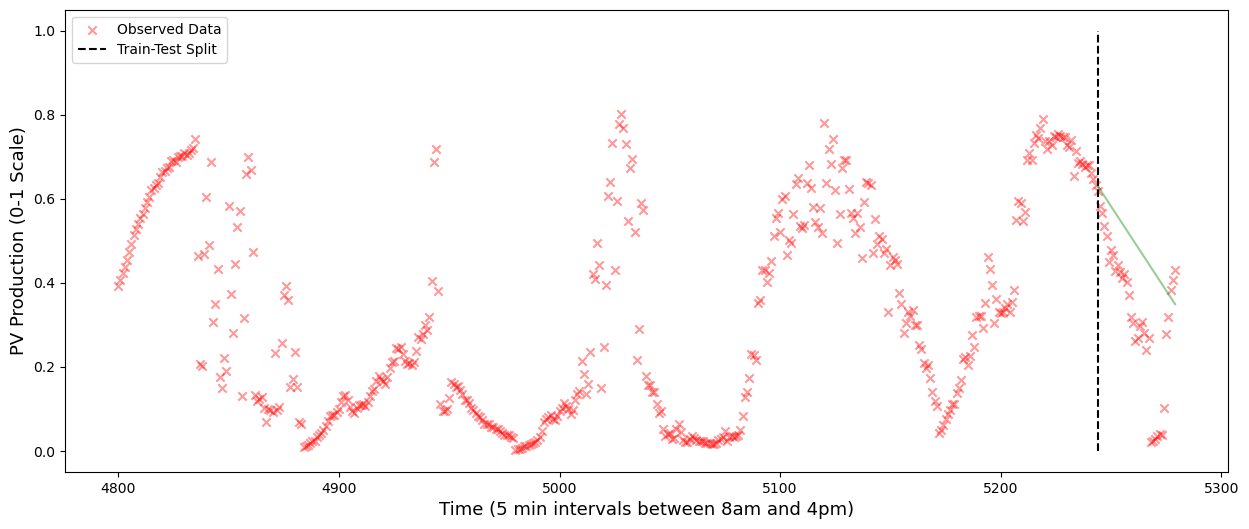

In [456]:
test = y_train[:, 6].numpy().shape

exp_model = ExponentialSmoothing(endog=y_train[:, 6].numpy(),
                                 trend='add',
                                 )
exp_model.fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False, use_brute=True)
y_pred = exp_model.predict(params=exp_model.params, start=len(y_train), end=len(y_test) + len(y_train) - 1)

plt.figure(figsize=(15, 6))
plt.scatter(time_train, y_train[:, 6], color='r', alpha=0.4, marker = 'x', label='Observed Data')
plt.scatter(time_test, y_test[:, 6], color='r', alpha=0.4, marker = 'x')

plt.vlines(x=len(y_train[:,0]) + time_train.min(), ymin=0, ymax=1, color='black', linestyle='--', label='Train-Test Split')
plt.plot(time_test, y_pred, color='g', alpha=0.4)

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)', fontsize=13)

plt.legend(loc='upper left')

In [427]:
model = ExponentialModels(y_train=y_train[:, idx].numpy(),
                          y_test=y_test[:, idx].numpy(),
                          trend ='add')

preds = model.single_exponential_smoothing(alpha=0.2)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'